In [ ]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.stats import kurtosis
from numpy import hamming  # Import hamming window function
import csv

# Define the directory containing the FITS files, and csv file path
directory = r"C:\Users\lsann\Desktop\TESTPREP\REAL CUBES"
params_path = r"C:\Users\lsann\Desktop\GitHub\ALMASim\almasim\metadata\calculated_params.csv"
# Directory to save the outputs
output_dir = r"C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to calculate dynamic threshold
def dynamic_threshold(data, sensitivity=1.0):
    mean, std = np.mean(data), np.std(data)
    threshold = mean + sensitivity * std
    return threshold

# Function to compute rolling mean
def rolling_mean(data, window=75):  # Change the window size to reach the optimal plot
    return np.convolve(data, np.ones(window) / window, mode='valid')

def apply_hamming_window(data):
    window = hamming(data.shape[0])[:, None, None] * hamming(data.shape[1])[None, :, None] * hamming(data.shape[2])[None, None, :]
    return data * window

def compute_and_plot_fourier_3d_full(data, title_prefix, output_dir):
    # Handle NaN values by replacing them with zero
    data = np.nan_to_num(data)

    # Apply Hamming window to the data before Fourier Transform
    data = apply_hamming_window(data)

    # Inizializza array per sommare le trasformate di Fourier di tutte le slice
    sum_fourier_transform = np.zeros_like(data[0, :, :], dtype=np.complex128)
    
    # Itera su tutte le slice lungo la terza dimensione del datacube
    for i in range(data.shape[0]):
        # Estrai la slice
        slice_data = data[i, :, :]
        
        # Gestisci eventuali valori NaN sostituendoli con zero (se necessario)
        slice_data = np.nan_to_num(slice_data)
        
        # Calcola la trasformata di Fourier per la slice
        fourier_transform = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(slice_data)))
        
        # Somma la trasformata di Fourier di ogni slice
        sum_fourier_transform += fourier_transform

    # Calcola la magnitudine e la fase della somma delle trasformate
    magnitude_transform = np.abs(sum_fourier_transform)
    phase_transform = np.angle(sum_fourier_transform)

    # Verifica se i dati della trasformata di Fourier sono vuoti o quasi vuoti
    if np.all(magnitude_transform == 0):
        print(f"Warning: Fourier Transform resulted in an empty plot for {title_prefix}.")
        return

    # Scala logaritmica per una migliore visualizzazione
    #magnitude_display = np.log10(magnitude_transform)  # Aggiungi una piccola costante per evitare log(0)
    
    # Plotting
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(magnitude_transform, cmap='gray', origin='lower')
    plt.title('Magnitude')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(phase_transform, cmap='hsv', origin='lower')
    plt.title('Phase')
    plt.colorbar()

    plt.tight_layout()

    # Salva il plot
    output_path = os.path.join(output_dir, f'{title_prefix}_fourier_summed.png')
    plt.savefig(output_path)
    plt.close()

    print(f"Fourier transform summed plots saved for {title_prefix} in {output_dir}")


results = []
mean_flux_rolling_data = []
# Process each FITS file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".fits"):
        file_path = os.path.join(directory, filename)
        
        # Load the data using memmap to handle large files
        HDUL = fits.open(file_path, memmap=True)
        data = HDUL[0].data

        # Create an output directory for each target
        target_dir = os.path.join(output_dir, os.path.splitext(filename)[0])
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)

        results_file = os.path.join(target_dir, "results.txt")

        try:
            # Apply Gaussian smoothing to enhance faint sources
            smoothed_data = gaussian_filter(data, sigma=1)  # <-- Commented out
            
            # Integrated flux map
            integrated_flux = np.nansum(smoothed_data, axis=0)  # Changed 'smoothed_data' to 'data'
            total_flux = np.nansum(integrated_flux)

            # Integrated cube 
            integrated_image = np.nansum(smoothed_data, axis=0)

            # Center of the image
            center_of_image = np.array([integrated_flux.shape[0] // 2, integrated_flux.shape[1] // 2])

            # Exclude a larger margin around the edges to prevent detecting noise or artifacts
            margin = 20  # Larger margin to exclude edges
            integrated_flux[:margin, :] = 0
            integrated_flux[-margin:, :] = 0
            integrated_flux[:, :margin] = 0
            integrated_flux[:, -margin:] = 0

            # 90% Threshold for source detection
            threshold = 0.96 * np.max(integrated_flux)

            # Find the source coordinates (x_center, y_center) in the integrated flux map
            y_center, x_center = np.unravel_index(np.argmax(integrated_flux > threshold), integrated_flux.shape)
            center_of_source = np.array([y_center, x_center])

            # Identify the slice that contains the maximum flux at the source coordinates
            source_spectrum = data[:, y_center, x_center]
            max_slice_index = np.argmax(source_spectrum)

            # Extract the 2D data from this slice
            slice_data = integrated_flux

            # Detect small sources: 1 to 4 pixels
            small_source = np.sum(slice_data > threshold) <= 4
            if small_source:
                # Calculate source radius based on the number of pixels
                num_pixels = np.sum(slice_data > threshold)
                if num_pixels == 1:
                    source_radius = 0.5  # Radius for 1 pixel flux
                else:
                    source_radius = 1.0  # Radius for 2-4 pixel flux
            else:
                # Calculate the source radius based on 90% of the maximum flux in the selected slice
                y, x = np.indices(slice_data.shape)
                r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
                r = r.astype(int)

                tbin = np.bincount(r.ravel(), slice_data.ravel())
                nr = np.bincount(r.ravel())
                radialprofile = tbin / nr

                radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)
                flux_threshold = 0.9 * np.max(radialprofile_smooth)
                source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
                if source_radius == 0:
                    source_radius = np.argmax(radialprofile_smooth > 0)

            sigma_fit = source_radius / 2.0

            # Adjust the mask creation based on slice_data shape
            y, x = np.indices(slice_data.shape)
            source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2
            inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (6 * sigma_fit)**2
            outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (9 * sigma_fit)**2
            background_mask = inner_annulus & outer_annulus

            # Calculate mean source and standard deviation of background
            mean_source = np.mean(integrated_flux[source_mask])
            std_background = np.std(integrated_flux[background_mask])

            # Calculate the SNR for the selected slice
            overall_snr = mean_source / std_background if std_background != 0 else 0

            # Calculate kurtosis of the selected slice
            kurt = kurtosis(slice_data.ravel(), fisher=True) if slice_data.size > 0 else 0

            # # Compute mean flux, std, and SNR for all slices
            mean_fluxes = []
            std_backgrounds = []
            snr_values = []

            for i in range(data.shape[0]):
                slice_data = data[i]
                mean_flux = np.mean(slice_data[source_mask])
                mean_fluxes.append(mean_flux)
                std_background = np.std(slice_data[background_mask])
                std_backgrounds.append(std_background)
                snr = mean_flux / std_background if std_background != 0 else 0
                snr_values.append(snr)

            # Check if SNR is NaN or 0.0, and apply zoom-in and variable threshold if needed
            if np.isnan(overall_snr) or overall_snr == 0.0:
                # Apply dynamic threshold
                threshold = dynamic_threshold(integrated_flux, sensitivity=1.5)
                y_center, x_center = np.unravel_index(np.argmax(integrated_flux > threshold), integrated_flux.shape)
                source_spectrum = data[:, y_center, x_center]
                max_slice_index = np.argmax(source_spectrum)
                slice_data = data[max_slice_index]

                # Recalculate source and background masks
                y, x = np.indices(slice_data.shape)
                r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
                source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2
                inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (6 * sigma_fit)**2
                outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (9 * sigma_fit)**2
                background_mask = inner_annulus & outer_annulus

                mean_source = np.mean(integrated_flux[source_mask])
                std_background = np.std(integrated_flux[background_mask])
                overall_snr = mean_source / std_background if std_background != 0 else 0

            # Apply rolling mean to flux, std, and snr
            mean_flux_rolling = rolling_mean(mean_fluxes)
            std_background_rolling = rolling_mean(std_backgrounds)
            snr_rolling = rolling_mean(snr_values)

            # Save results to the text file
            with open(results_file, "w") as f:
                f.write(f"Name of target: {filename}\n")
                f.write(f"center_of_image: {[integrated_flux.shape[0] // 2, integrated_flux.shape[1] // 2]}\n")
                f.write(f"center_of_source: {[y_center, x_center]}\n")
                f.write(f"source_radius: {source_radius}\n")
                f.write(f"sigma_fit: {sigma_fit}\n")
                f.write(f"overall_snr: {overall_snr}\n")
                f.write(f"kurtosis: {kurt}\n")
                f.write(f"RMS of the Noise: {std_background}\n")  # Added line
                f.write(f"Source flux: {np.mean(mean_source)}\n")
                f.write(f"Total flux of the cube: {total_flux}\n")
            
            # Fourier Transform
            #compute_and_plot_fourier_3d_full(data, os.path.splitext(filename)[0], target_dir)
            
            # Plot SNR
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(snr_values)), snr_values, label='SNR')
            plt.xlabel('Slice Index')
            plt.ylabel('SNR')
            plt.title(f'{os.path.splitext(filename)[0]} - SNR Across All Slices')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_snr_across_slices.png'))
            plt.close()

            # Plot rolling mean flux
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(mean_flux_rolling)), mean_flux_rolling, label='Mean Flux', color='green')
            plt.xlabel('Slice Index')
            plt.ylabel('Mean Flux')
            plt.title(f'{os.path.splitext(filename)[0]} - Mean Flux (Rolling Mean)')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_mean_flux_across_slices_rolling_mean.png'))
            plt.close()

            # Plot RMS of the Noise
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(std_background_rolling)), std_background_rolling, label='RMS', color='red')
            plt.xlabel('Slice Index')
            plt.ylabel('Standard Deviation')
            plt.title(f'{os.path.splitext(filename)[0]} - RMS of the Noise')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_rms_noise.png'))
            plt.close()

            # Pixel flux distribution of the integrated cube
            plt.figure(figsize=(10, 6))
            plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
            plt.xlabel('Pixel Flux')
            plt.ylabel('Number of Pixels')
            plt.title(f'{os.path.splitext(filename)[0]} - Pixel Flux Distribution of the Selected Slice')
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_pixel_flux_distribution.png'))
            plt.close()

            # Visualize the source and background regions
            plt.figure(figsize=(6, 6))
            plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
            plt.title(f'{os.path.splitext(filename)[0]} - Source (Green) and Background (Yellow) Regions')
            plt.colorbar(label='Region Mask')
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_source_and_background_regions.png'))
            plt.close()
            
            # Saving integrated cube plot
            plt.figure(figsize=(10, 8))
            plt.imshow(integrated_image, origin='lower', cmap='viridis')
            plt.colorbar(label='Integrated Flux')
            plt.xlabel('RA (pixel)')
            plt.ylabel('DEC (pixel)')
            plt.title('Integrated Cube')
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_integrated_cube.png'))
            plt.close()

            results.append({
                'filename': filename,
                'integrated_flux': integrated_image
            })
            mean_flux_rolling_data.append({
                'filename': filename,
                'mean_flux_rolling': mean_flux_rolling
            })
        except MemoryError:
            print(f"MemoryError: Unable to process {filename} due to memory constraints.")
        
        finally:
            # Close the FITS file
            HDUL.close()
            
# if len(results) >= 2:
#     # Assuming results[0] and results[1] are the two files to compare
#     result1 = results[0]
#     result2 = results[1]

#     # Plot the comparison between integrated flux of the two files
#     plt.figure(figsize=(10, 8))
    
#     plt.subplot(1, 2, 1)
#     im1 = plt.imshow(result1['integrated_flux'], origin='lower', cmap='viridis')
#     plt.title(f'Integrated Cube Real Obs.')
#     plt.colorbar(im1 , label = 'Integrated Flux', fraction=0.046, pad=0.04)

#     plt.subplot(1, 2, 2)
#     im2 = plt.imshow(result2['integrated_flux'], origin='lower', cmap='viridis')
#     plt.title(f'Integrated Cube Simulated Obs.')
#     plt.colorbar(im2,label = 'Integrated Flux',fraction=0.046, pad=0.04)

#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'integrated_flux_comparison.png'))
#     plt.close()

# if len(mean_flux_rolling_data) >= 2:
#     # Assuming mean_flux_rolling_data[0] and mean_flux_rolling_data[1] are the two files to compare
#     result1 = mean_flux_rolling_data[0]
#     result2 = mean_flux_rolling_data[1]

#     # Plot the comparison between rolling mean flux of the two files
#     plt.figure(figsize=(12, 6))
#     plt.plot(result1['mean_flux_rolling'], label='Real Mean Flux', color='blue')
#     plt.plot(result2['mean_flux_rolling'], label='Simulated Mean Flux', color='orange')
#     plt.xlabel('Slice Index')
#     plt.ylabel('Mean Flux')
#     plt.title('Mean Flux Comparison (Rolling Mean)')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(os.path.join(output_dir, 'mean_flux_comparison_rolling_mean.png'))
#     plt.close()

#     print(f"Comparison plots saved in {output_dir}")

print(f"Processing complete. Results saved in {output_dir}")


In [8]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.stats import kurtosis
from numpy import hamming  # Import hamming window function
import csv
import pandas as pd

# Percorso della directory madre
output_dir = r"C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES"
csv_file_path = r"C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\parameter_data.csv"

# Keywords for finding values in the text file
keywords = {
    "source_flux": "Source flux:",
    "total_flux": "Total flux of the cube:",
    "overall_snr": "overall_snr:",
    "rms_noise": "RMS of the Noise:"
}

# Function to extract value from line by keyword
def extract_value_from_line(line, keyword):
    if keyword in line:
        try:
            # Extract the part after the keyword and convert it to float
            return float(line.split(keyword)[1].strip())
        except ValueError:
            return None
    return None

# Create CSV and write the header
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['file', 'source_flux', 'total_flux', 'overall_snr', 'rms_noise']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    # Traverse the directory and process text files
    for root, dirs, files in os.walk(output_dir):
        print(f"Processing directory: {root}")
        for file in files:
            if file.endswith(".txt"):  # Assumiamo che i file siano file di testo
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    row = {'file': file}
                    # Initialize values for each keyword
                    for key in keywords.keys():
                        row[key] = None

                    # Process each line
                    for line in f:
                        for key, keyword in keywords.items():
                            value = extract_value_from_line(line, keyword)
                            if value is not None:
                                row[key] = value

                    # Write extracted values to CSV, replacing None with 'NaN'
                    writer.writerow({k: v if v is not None else 'NaN' for k, v in row.items()})

# Read the CSV and process data
df = pd.read_csv(csv_file_path)

# Replace 'NaN' with 0.0
df = df.replace('NaN', np.nan).fillna(0.0)

# Convert all columns except 'file' to float
for col in df.columns[1:]:
    df[col] = df[col].astype(float)

# Calculate statistics for each parameter
statistics = {}
for col in df.columns[1:]:
    statistics[col] = {
        'mean': np.abs(df[col]).mean(),
        'max.': df[col].max(),
        'min.': df[col].min()
    }

# Print the results
print("Statistical values:")
for key, stat in statistics.items():
    print(f"{key.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {stat['mean']}")
    print(f"  Max.: {stat['max.']}")
    print(f"  Min.: {stat['min.']}")

Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\cropped_J0842+12_a_06_TM1_muid___A001_X885_X36b
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\cropped_J0842+12_a_08_TM1_muid___A001_X1590_X1ef6
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\cropped_J1306+03_a_06_TE_muid___A001_X2fb_X40c
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\cropped_J1306+03_a_06_TM1_muid___A001_X1273_X374
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\cropped_J1306+03_a_08_TM1_muid___A001_X1590_X1f02
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\cropped_J1319+0950_266GHz_12m_C32-6_muid___A002_X7fb989_X18
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES\c

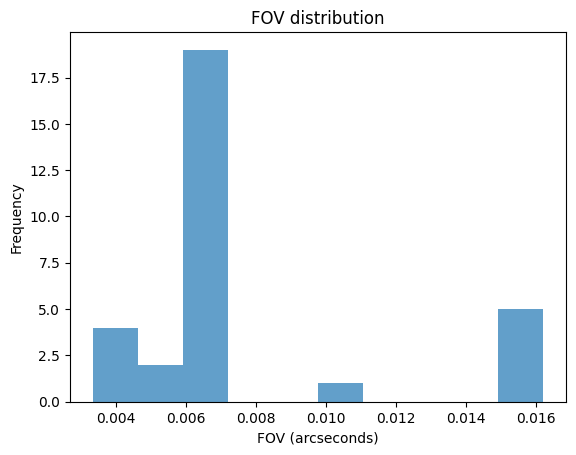

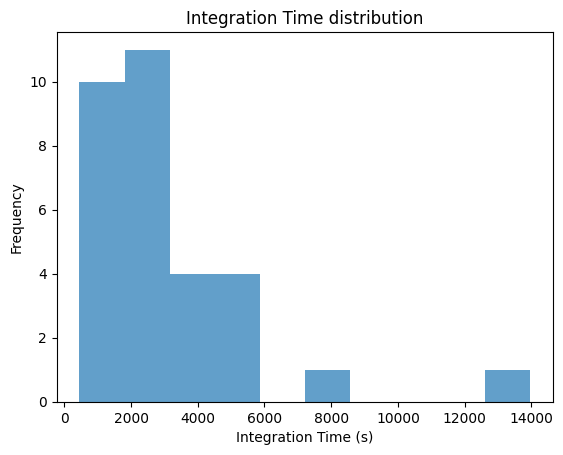

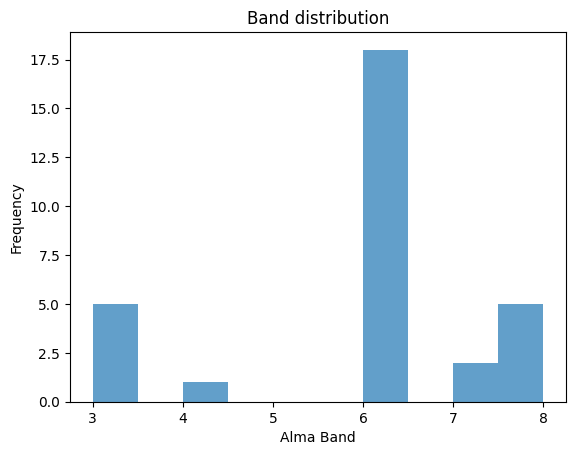

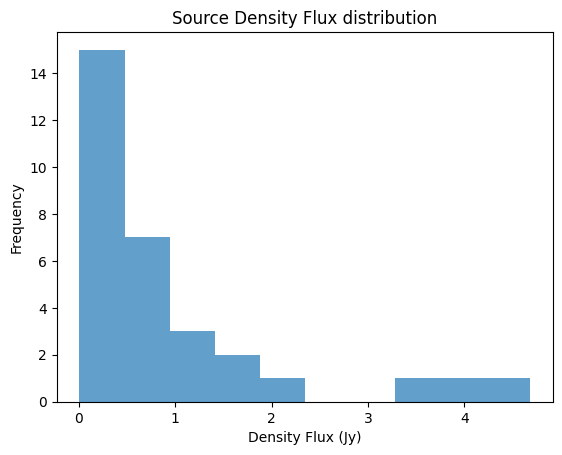

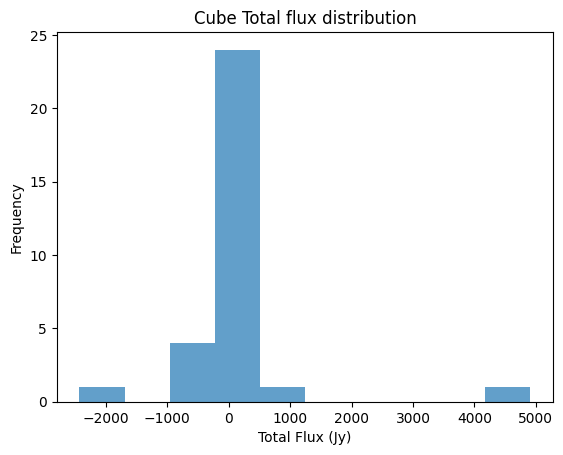

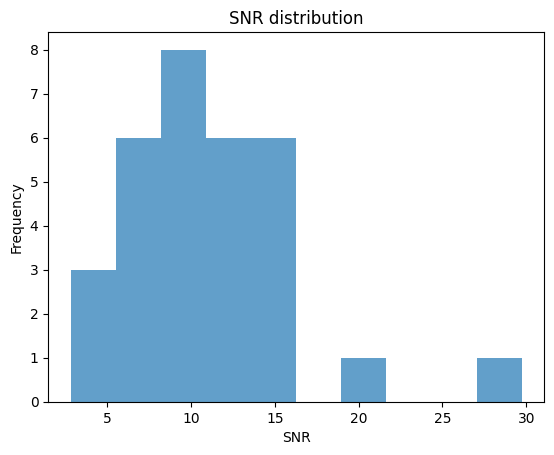

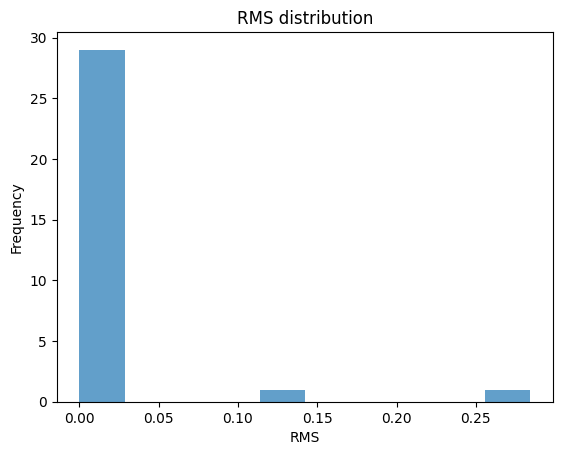

In [17]:
df2 = pd.read_csv(r"C:\Users\lsann\Desktop\GitHub\ALMASim\almasim\metadata\qso_metadata.csv")

df2['FOV'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('FOV (arcseconds)')
plt.ylabel('Frequency')
plt.title('FOV distribution')
plt.show()

df2['Int.Time'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Integration Time (s)')
plt.ylabel('Frequency')
plt.title('Integration Time distribution')
plt.show()

df2['Band'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Alma Band')
plt.ylabel('Frequency')
plt.title('Band distribution')
plt.show()

df['source_flux'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Density Flux (Jy)')
plt.ylabel('Frequency')
plt.title('Source Density Flux distribution')
plt.show()

df['total_flux'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Total Flux (Jy)')
plt.ylabel('Frequency')
plt.title('Cube Total flux distribution')
plt.show()

df['overall_snr'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('SNR distribution')
plt.show()

df['rms_noise'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('RMS')
plt.ylabel('Frequency')
plt.title('RMS distribution')
plt.show()